In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and preprocess data
data_dir = "C:/Users/OneDrive/Desktop/oral cancer dataset/Oral Cancer"
labels = os.listdir(data_dir)
filepaths = []
for label in labels:
    folder_path = os.path.join(data_dir, label)
    filepaths.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path)])

In [3]:
# Create DataFrame
df = pd.DataFrame({"filepaths": filepaths, "labels": [os.path.basename(os.path.dirname(path)) for path in filepaths]})

In [4]:
# Train-test split
train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(test_df, test_size=1/3, shuffle=True, random_state=123)


In [5]:
# Image parameters
batch_size = 128
img_size = (224, 224)


In [6]:
# Data Generators
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
valid_gen = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7001 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.


In [7]:
# Base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Custom head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.36),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.36),
    Dense(len(labels), activation='softmax')
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               1

In [11]:
# Train the model
history = model.fit(train_gen,
                    epochs=40,
                    validation_data=valid_gen)

Epoch 1/40
55/55 [==============================] - 5544s 102s/step - loss: 0.6946 - accuracy: 0.6909 - val_loss: 0.4948 - val_accuracy: 0.7640
Epoch 2/40
55/55 [==============================] - 756s 14s/step - loss: 0.4882 - accuracy: 0.7722 - val_loss: 0.4529 - val_accuracy: 0.7805
Epoch 3/40
55/55 [==============================] - 755s 14s/step - loss: 0.4408 - accuracy: 0.8042 - val_loss: 0.3859 - val_accuracy: 0.8215
Epoch 4/40
55/55 [==============================] - 756s 14s/step - loss: 0.3886 - accuracy: 0.8212 - val_loss: 0.3453 - val_accuracy: 0.8510
Epoch 5/40
55/55 [==============================] - 756s 14s/step - loss: 0.3680 - accuracy: 0.8386 - val_loss: 0.3222 - val_accuracy: 0.8625
Epoch 6/40
55/55 [==============================] - 757s 14s/step - loss: 0.3547 - accuracy: 0.8443 - val_loss: 0.3001 - val_accuracy: 0.8725
Epoch 7/40
55/55 [==============================] - 755s 14s/step - loss: 0.3265 - accuracy: 0.8597 - val_loss: 0.3203 - val_accuracy: 0.8665
Epoc

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

8/8 [==============================] - 88s 11s/step - loss: 0.1487 - accuracy: 0.9441
Test Loss: 0.1487293541431427
Test Accuracy: 0.9440559148788452


In [13]:
# Confusion matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(true_classes, y_pred_classes)

8/8 [==============================] - 108s 13s/step


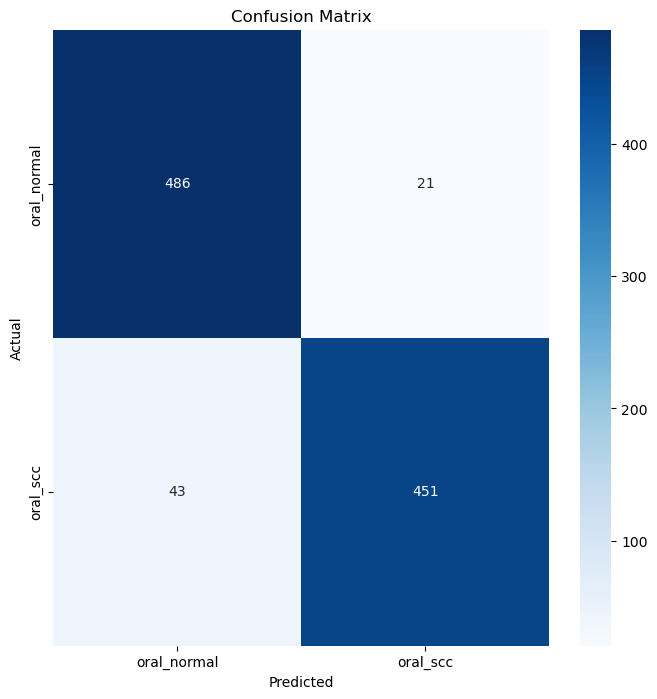

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

 oral_normal       0.92      0.96      0.94       507
    oral_scc       0.96      0.91      0.93       494

    accuracy                           0.94      1001
   macro avg       0.94      0.94      0.94      1001
weighted avg       0.94      0.94      0.94      1001



In [ ]:
model.save(r'C:/Users/OneDrive/Desktop/Densenet 201/40 epochs/densenet201_40.h5')
model1 = tf.keras.models.load_model(r'C:/Users/OneDrive/Desktop/Densenet 201/40 epochs/Densenet201_40.h5')